In [50]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from statistics import mean

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [51]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


### 1: Load data

torch.Size([256, 3, 192, 256])

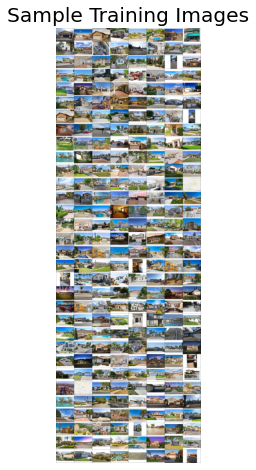

In [52]:
IMAGE_SIZE = (192, 256)
BATCH_SIZE = 256

data_dir = "../input/house-prices-and-images-socal/socal2"

# transformer setup
transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = datasets.ImageFolder(root=data_dir, transform=transformer)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False
                                          )

sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

# to confirm the shape of input data
next(iter(data_loader))[0].shape

### 2: Create the Generator

In [54]:
# def bede(n, stride, padding, dilation, filters):
#     return (n - 1) * stride - 2 * padding + dilation * (filters - 1) + 1


# a = bede(n=64, stride=2, padding=1, dilation=1, filters=4)
# a

In [55]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super().__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            
            nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=(3, 4), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
                    
            # output dim: [-1, 512, 3, 4]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 256, 6, 8]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 128, 12, 16]

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 64, 24, 32]
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 32, 48, 64]
         
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 3, 96, 128]
            
            nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 3, 233, 311]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 233, 311]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [56]:
# g= G(96)
# summary(g, (96, 1, 1))

### 3: Create the Discriminator

In [57]:
# discriminator = models.resnet18(pretrained=True)
# # list(discriminator.named_children())

In [58]:
# last_layer = nn.Sequential(
#         nn.Linear(512, 1),
# #         nn.Flatten(),
#         nn.Sigmoid()
#         )
# discriminator.fc = last_layer
# #summary(discriminator, (3, 233, 311))

In [59]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
        
            # input dim: [-1, 3, 192, 256]
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 64, 96, 128]

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 64, 48, 64]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 128, 24, 32]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 256, 12, 16]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 512, 6, 8]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.4, inplace=True),
            
            # output dim: [-1, 1, 3, 5]

            nn.Flatten(),
            
            # output dim: [-1, 12]
            
            nn.Linear(15, 1),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

### 4: Initialize Weights

GANs can be quite sensitive to the initial weights assigned to each layer when we instantiate the model. We instantiate the generator and discriminator and then specify their initial weights as follows:
- `Conv2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `ConvTranspose2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `BatchNorm2d()` layers: normal distribution with `mean=1.0` and `std=0.02` for the weights, zeroes for the biases

In [60]:
# initiate generator (discriminator already initiated)
LATENT_SIZE = 96
generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=0.4)
optimizerD = optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=0.4)

# summary(generator, (96, 1, 1))

In [61]:
# summary(discriminator, (3, 192, 256))

In [62]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

### 5: Train your GAN

I have used [tips and tricks for training GANs](https://github.com/soumith/ganhacks) to finetune the GAN model.

In [63]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

In [64]:
NUM_EPOCHS = 20

print('Training started:\n')

D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

for epoch in range(NUM_EPOCHS):
    
    D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []
    
    for real_batch, _ in data_loader:

        # STEP 1: train discriminator
        # ==================================
        # Train with real data
        discriminator.zero_grad()
        
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)
        
        output = discriminator(real_batch).view(-1)
        loss_real = criterion(output, real_labels)
        
        # Iteration book-keeping
        D_real_iter.append(output.mean().item())
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)
        
        fake_batch = generator(noise)
        fake_labels = torch.zeros_like(real_labels)
        
        output = discriminator(fake_batch.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        
        # Update discriminator weights
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optimizerD.step()
        
        # Iteration book-keeping
        loss_dis_iter.append(loss_dis.mean().item())
        D_fake_iter.append(output.mean().item())
        
        # STEP 2: train generator
        # ==================================
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        
        # Book-keeping
        loss_gen_iter.append(loss_gen.mean().item())
        
        # Update generator weights and store loss
        optimizerG.step()
        
    print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})\t",
          f"Loss_G: {mean(loss_gen_iter):.4f}",
          f"Loss_D: {mean(loss_dis_iter):.4f}\t",
          f"D_real: {mean(D_real_iter):.4f}",
          f"D_fake: {mean(D_fake_iter):.4f}")
    
    # Epoch book-keeping
    loss_gen_epoch.append(mean(loss_gen_iter))
    loss_dis_epoch.append(mean(loss_dis_iter))
    D_real_epoch.append(mean(D_real_iter))
    D_fake_epoch.append(mean(D_fake_iter))
    
    # Keeping track of the evolution of a fixed noise latent vector
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))
        
print("\nTraining ended.")

Training started:

Epoch (1/20)	 Loss_G: 1.1592 Loss_D: 0.8634	 D_real: 0.6698 D_fake: 0.3616
Epoch (2/20)	 Loss_G: 1.4940 Loss_D: 0.6072	 D_real: 0.7525 D_fake: 0.2730
Epoch (3/20)	 Loss_G: 1.9238 Loss_D: 0.4075	 D_real: 0.8017 D_fake: 0.1691
Epoch (4/20)	 Loss_G: 2.2375 Loss_D: 0.2975	 D_real: 0.8431 D_fake: 0.1187
Epoch (5/20)	 Loss_G: 2.4640 Loss_D: 0.2259	 D_real: 0.8788 D_fake: 0.0921
Epoch (6/20)	 Loss_G: 2.7224 Loss_D: 0.1732	 D_real: 0.9044 D_fake: 0.0701
Epoch (7/20)	 Loss_G: 1.6830 Loss_D: 0.8659	 D_real: 0.7161 D_fake: 0.3265
Epoch (8/20)	 Loss_G: 1.7867 Loss_D: 0.8156	 D_real: 0.7234 D_fake: 0.3067
Epoch (9/20)	 Loss_G: 1.3758 Loss_D: 1.1028	 D_real: 0.6709 D_fake: 0.4215
Epoch (10/20)	 Loss_G: 1.6584 Loss_D: 0.8638	 D_real: 0.7054 D_fake: 0.3438
Epoch (11/20)	 Loss_G: 1.3879 Loss_D: 1.1561	 D_real: 0.6250 D_fake: 0.4109
Epoch (12/20)	 Loss_G: 2.3335 Loss_D: 0.4427	 D_real: 0.8268 D_fake: 0.1830
Epoch (13/20)	 Loss_G: 2.8562 Loss_D: 0.1401	 D_real: 0.9330 D_fake: 0.0679
Ep

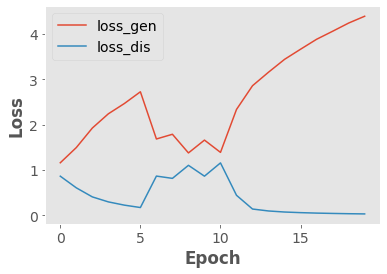

In [65]:
plt.plot(np.array(loss_gen_epoch), label='loss_gen')
plt.plot(np.array(loss_dis_epoch), label='loss_dis')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

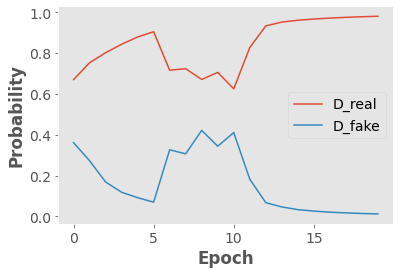

In [66]:
plt.plot(np.array(D_real_epoch), label='D_real')
plt.plot(np.array(D_fake_epoch), label='D_fake')
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend();

In [67]:
%%capture

fig = plt.figure(figsize=(10, 10))
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GAN.gif', writer='imagemagick', fps=2)

In [68]:
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation